In [13]:
import sys
sys.path.append('../')

from src.cmesrc.config import CMESRCV2_DB
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
conn = sqlite3.connect(CMESRCV2_DB)
c = conn.cursor()
conn.execute("PRAGMA foreign_keys = ON")

In [8]:
comp = pd.read_sql("""
SELECT M.cme_id, C.cme_quality, M.sr_type, M.sr_lon, M.sr_lat, M.matching_harps AS majumdar, FCHA.harpnum AS mine, HBB.overlap_harpnum AS overlap, FCHA.verification_score, M.cme_pa, M.cme_width, M.sr_pa
FROM MAJUMDAR_SRC M
JOIN FINAL_CME_HARP_ASSOCIATIONS FCHA
ON M.cme_id = FCHA.cme_id
JOIN CMES C
ON C.cme_id = M.cme_id
JOIN PROCESSED_HARPS_BBOX HBB
ON HBB.timestamp = C.image_timestamp AND HBB.harpnum = FCHA.harpnum
ORDER BY verification_score
                   """, conn) # Get the comparsion data

In [9]:
comp.to_csv("/home/julio/Downloads/comparison.csv", index=False)

In [6]:
# Stacked histogram plot by sr_type with whether majumdar and mine match



,cme_id,cme_quality,sr_type,majumdar,mine,overlap,verification_score,cme_pa,cme_width,sr_pa
0,20110324124807038,0,AR,437.0,437,443.0,1.0,38.0,191.0,106.198413
1,20110529212408107,0,AP,637.0,637,NaN,1.0,107.0,186.0,110.509007
2,20120327031209319,0,AR,1492.0,1492,NaN,1.0,319.0,162.0,350.691082
3,20120603181205071,0,AP,1722.0,1722,NaN,1.0,71.0,180.0,61.941261
4,20120702202405185,0,AR,1807.0,1807,1820.0,1.0,185.0,145.0,180.000000
...,...,...,...,...,...,...,...,...,...,...
207,20131201203605331,0,AP,3420.0,3420,NaN,5.0,331.0,159.0,308.719616
208,20131211073607193,0,AP,3473.0,3465,3474.0,5.0,193.0,79.0,121.623025
209,20140103180006154,0,PE,NaN,3576,3574.0,5.0,154.0,60.0,149.836301
210,20140105083605058,0,AR,3560.0,3580,NaN,5.0,58.0,98.0,38.114098


In [10]:
df = pd.read_csv("/home/julio/pa_results.csv")

In [20]:
get_min = lambda x, y: min(np.abs(x - y), 360 - np.abs(x - y))
df["diff"] = df.apply(lambda x: get_min(x["cme_pa"], x["sr_pa"]), axis=1)
df["normalized_diff"] = df["diff"] / df["cme_width"]

In [27]:
get_problematic_outside_bounds = lambda diff, cme_width: diff > (cme_width + 20) / 2
get_problematic_normalized_idff = lambda normalized_diff: normalized_diff > 0.5

df["problematic_outside_bounds"] = df.apply(lambda x: get_problematic_outside_bounds(x["diff"], x["cme_width"]), axis=1)
df["problematic_normalized_diff"] = df.apply(lambda x: get_problematic_normalized_idff(x["normalized_diff"]), axis=1)

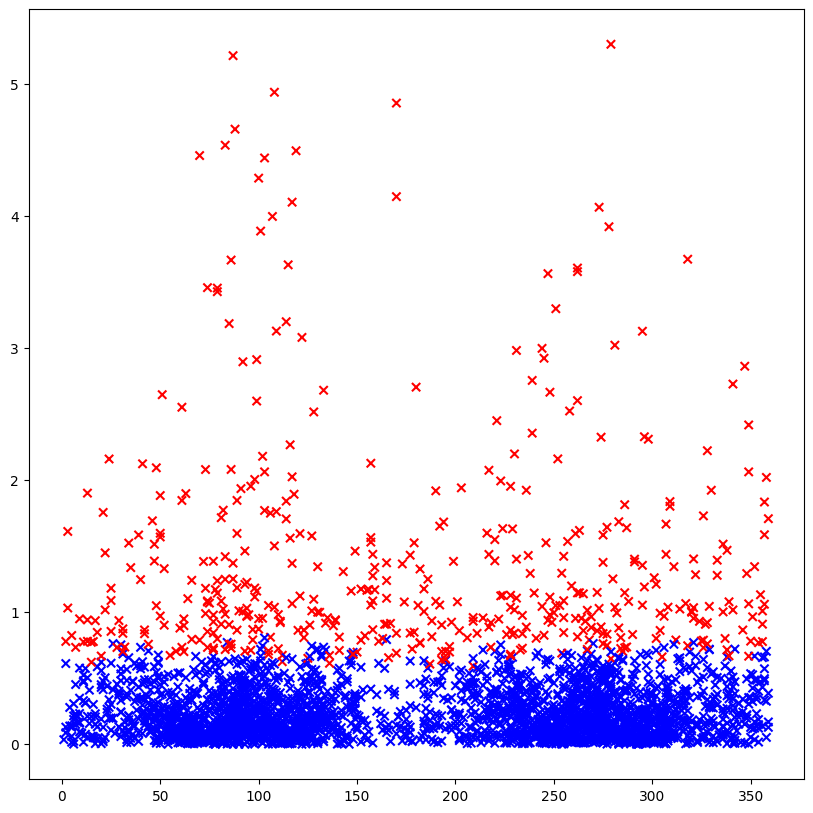

In [30]:
# Scatter plot of cme_pa vs normalized_diff with problematic_normalized_diff as color red, otherwise blue

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(df["cme_pa"], df["normalized_diff"], c=df["problematic_outside_bounds"], marker="x", cmap="bwr")

In [ ]:
df.to_csv("norm_pa_results.csv", index=False)